# Train classifiers

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

In [4]:
use_extracted_data = True


In [5]:
import os
import time
import warnings
from datetime import timedelta

import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.check_files import check_prepared_data
from lib.feature_selection import (
    create_dendrogram,
    select_features,
)
from lib.pu import (
    BASE_MODELS,
    PU_PARAMS,
    COLUMNS_TO_DROP,
    PRESERVATION_COLUMNS,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning

warnings.simplefilter("ignore", FutureWarning)


env: PYTHONWARNINGS=ignore::FutureWarning


In [6]:
# Random seed for reproducibility
random_seed = 1234

# Number of jobs used to train model
n_jobs = int(os.environ.get("N_JOBS", 8))

# Parameters for models
imputer_params = {
    "random_state": random_seed,
    "add_indicator": False,
}
rf_params = {"random_state": random_seed}
pu_params = {
    "n_jobs": n_jobs,
    "random_state": random_seed,
    **PU_PARAMS
}
svm_params = {
    "kernel": "rbf",
    "probability": True,
    "random_state": random_seed,
}


In [7]:
# Input/output files
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
data_filename = os.path.join(data_dir, "training_data_global.csv")

output_dir = os.path.join("outputs", "global")
os.makedirs(output_dir, exist_ok=True)

dendro_dir = os.path.join(output_dir, "correlation_dendrograms")
os.makedirs(dendro_dir, exist_ok=True)
dendro_filename = os.path.join(dendro_dir, "correlation_dendrogram.png")
selected_features_filename = os.path.join(output_dir, "selected_features.csv")

pu_dir = os.path.join(output_dir, "PU")
os.makedirs(pu_dir, exist_ok=True)
pu_filename = os.path.join(pu_dir, "classifier.joblib")

svm_dir = os.path.join(output_dir, "SVM")
os.makedirs(svm_dir, exist_ok=True)
svm_filename = os.path.join(svm_dir, "classifier.joblib")


In [8]:
data = pd.read_csv(data_filename)

# Equal number of positive and unlabelled samples
negatives = data[data["label"] == "negative"]
tmp = data[data["label"] != "negative"]
tmp_downsampled = downsample_unlabelled(
    tmp,
    random_state=random_seed,
)
combined = pd.concat((tmp_downsampled, negatives))
cleaned = combined.drop(
    columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
    errors="ignore",
)
del tmp, tmp_downsampled

print(combined.groupby(["region", "label"]).size())


region          label     
East Asia       negative         7
                positive         4
                unlabelled      84
North America   negative        57
                positive       259
                unlabelled     136
Other           negative       218
                positive         1
                unlabelled      73
South America   negative      1100
                positive       212
                unlabelled      92
Southeast Asia  negative         4
                positive        51
                unlabelled     111
Tethys          negative        20
                positive        80
                unlabelled     111
dtype: int64


## Select uncorrelated features

### Global

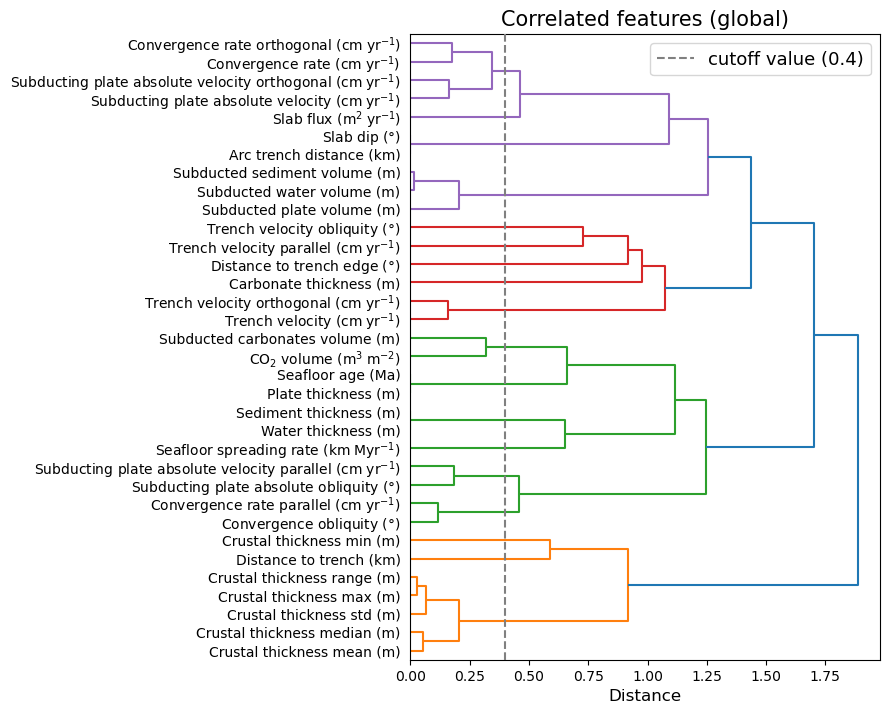

In [11]:
transformer = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
).set_output(transform="pandas")
X = transformer.fit_transform(cleaned.drop(columns="label"))

distance_threshold = 0.4
dendro = create_dendrogram(
    X,
    show_plot=True,
    dendro_kwargs=dict(
        orientation="right",
    ),
    distance_threshold=distance_threshold,
    thresh_kwargs=dict(
        label=f"cutoff value ({distance_threshold:0.1f})",
    )
)
dendro.figure.axes[0].set_title("Correlated features (global)", fontsize=15)
dendro.figure.axes[0].legend(fontsize=13)

dendro.figure.savefig(dendro_filename, dpi=400, bbox_inches="tight")

In [12]:
features_table = []
features_dict = {}

selected_features = select_features(
    dendro.distances,
    distance_threshold,
    names=X.columns,
)
excluded_features = set(X.columns) - set(selected_features)

features_table.append(
    pd.Series(
        [i in selected_features for i in cleaned.drop(columns="label").columns.to_list()],
        index=cleaned.drop(columns="label").columns.to_list(),
        name="Global",
    )
)
features_dict["Global"] = selected_features

print(
    "Excluded the following "
    f"{len(excluded_features)} features:"
)
for i in sorted(excluded_features):
    print(f" - {i}")

print(
    "Keeping the following "
    f"{len(selected_features)} features"
)
for i in sorted(selected_features):
    print(f" - {i}")


Excluded the following 16 features:
 - convergence_rate (cm/yr)
 - convergence_rate_orthogonal (cm/yr)
 - convergence_rate_parallel (cm/yr)
 - crustal_thickness_max (m)
 - crustal_thickness_median (m)
 - crustal_thickness_range (m)
 - crustal_thickness_std (m)
 - seafloor_age (Ma)
 - sediment_thickness (m)
 - slab_dip (degrees)
 - subducted_carbonates_volume (m)
 - subducted_sediment_volume (m)
 - subducted_water_volume (m)
 - subducting_plate_absolute_velocity_orthogonal (cm/yr)
 - subducting_plate_absolute_velocity_parallel (cm/yr)
 - trench_velocity_orthogonal (cm/yr)
Keeping the following 18 features
 - arc_trench_distance (km)
 - carbonate_thickness (m)
 - co2_volume (m^3/m^2)
 - convergence_obliquity (degrees)
 - crustal_thickness_mean (m)
 - crustal_thickness_min (m)
 - distance_to_trench (km)
 - distance_to_trench_edge (degrees)
 - plate_thickness (m)
 - seafloor_spreading_rate (km/Myr)
 - slab_flux (m^2/yr)
 - subducted_plate_volume (m)
 - subducting_plate_absolute_obliquity (

### By region

In [13]:
for region, subset in combined.groupby("region"):
    region = str(region)
    subset = subset.drop(
        columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
        errors="ignore",
    )
    print(f"Region: {region}")
    r = "_".join(region.lower().split())

    # Feature selection
    X_subset = clone(transformer).fit_transform(subset.drop(columns="label"))
    dendro_region = create_dendrogram(
        X_subset,
        show_plot=True,
        dendro_kwargs=dict(
            orientation="right",
        ),
        distance_threshold=distance_threshold,
        thresh_kwargs=dict(
            label=f"cutoff value ({distance_threshold:0.1f})",
        )
    )
    dendro_region.figure.axes[0].set_title(f"Correlated features ({region})", fontsize=15)
    dendro_region.figure.axes[0].legend(fontsize=13)
    dendro_region.figure.savefig(
        dendro_filename.replace(".png", f"_{r}.png"),
        dpi=400,
        bbox_inches="tight",
    )
    plt.close(dendro_region.figure)
    selected_features_region = select_features(
        dendro_region.distances,
        distance_threshold,
        names=X_subset.columns,
    )
    features_table.append(
        pd.Series(
            [i in selected_features_region for i in subset.drop(columns="label").columns.to_list()],
            index=subset.drop(columns="label").columns.to_list(),
            name=region,
        )
    )
    features_dict[region] = selected_features_region

features_table = pd.concat(features_table, axis="columns")
features_table = features_table.set_index(
    pd.Index(features_table.index, name="feature")
)
features_table.to_csv(selected_features_filename, index=True)

Region: East Asia
Region: North America
Region: Other
Region: South America
Region: Southeast Asia
Region: Tethys


## Train the PU models

### Global

In [14]:
# Wrangle training data
train_pu = cleaned[cleaned["label"].isin({"positive", "unlabelled"})]
x_pu = train_pu.drop(columns="label")
y_pu = train_pu["label"].replace({"positive": 1, "unlabelled": 0})

# Use a random forest as the base classifier
base_model = clone(BASE_MODELS["randomforest"])
base_model.set_params(**rf_params)

# Impute missing values and scale before training
pu_model = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
    #BaggingPuClassifier(base_estimator=base_model, **pu_params),
    BaggingPuClassifier(estimator=base_model, **pu_params),
)
pu_model.set_output(transform="pandas")

# Train model
t0 = time.time()
pu_model.fit(x_pu[selected_features], y_pu)

# Save to file
dump(pu_model, pu_filename, compress=True)
duration = timedelta(seconds=time.time() - t0)
print(f"Model training time: {duration}")


Model training time: 0:00:04.918254


### By region

In [ ]:
for region, subset in combined.groupby("region"):
    region = str(region)
    if (subset["label"] == "positive").sum() < 50:
        print(f"Skipping region: {region}")
        continue
    subset = subset.drop(
        columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
        errors="ignore",
    )
    print(f"Region: {region}")
    r = "_".join(region.lower().split())
    output_subset = os.path.join(
        pu_dir,
        f"classifier_{r}.joblib",
    )

    subset = subset[subset["label"].isin({"positive", "unlabelled"})]
    print(subset.groupby("label").size())
    x_pu_subset = subset.drop(columns="label")
    y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0})

    pu_model_subset = clone(pu_model)
    t0 = time.time()
    pu_model_subset.fit(x_pu_subset[features_dict[region]], y_pu_subset)
    dump(pu_model, output_subset, compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Model training time: {duration}")

    print("")

Skipping region: East Asia
Region: North America
label
positive      259
unlabelled    136
dtype: int64
Model training time: 0:00:03.086409

Skipping region: Other
Region: South America
label
positive      212
unlabelled     92
dtype: int64
Model training time: 0:00:02.743753

Region: Southeast Asia
label
positive       51
unlabelled    111
dtype: int64
Model training time: 0:00:02.803401

Region: Tethys
label
positive       80
unlabelled    111
dtype: int64


## Train the SVM models

### Global

In [ ]:
# Wrangle training data
train_svm = cleaned[cleaned["label"].isin({"positive", "negative"})]
x_svm = train_svm.drop(columns="label")
y_svm = train_svm["label"].replace({"positive": 1, "negative": 0})

# Impute missing values and scale before training
svm_model = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
    SVC(**svm_params),
)
svm_model.set_output(transform="pandas")

# Train model
t0 = time.time()
svm_model.fit(x_svm[features_dict["Global"]], y_svm)

# Save to file
dump(svm_model, svm_filename, compress=True)
duration = timedelta(seconds=time.time() - t0)
print(f"Model training time: {duration}")


### By region

In [ ]:
for region, subset in combined.groupby("region"):
    region = str(region)
    if (
        (subset["label"] == "positive").sum() < 50
        or (subset["label"] == "negative").sum() < 50
    ):
        print(f"Skipping region: {region}")
        print("")
        continue
    print(f"Region: {region}")
    r = "_".join(region.lower().split())
    output_subset = os.path.join(
        svm_dir,
        f"classifier_{r}.joblib",
    )

    subset = subset[subset["label"].isin({"positive", "negative"})]
    print(subset.groupby("label").size())
    x_svm_subset = subset.drop(columns="label")
    y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0})

    svm_model_subset = clone(svm_model)
    t0 = time.time()
    svm_model_subset.fit(x_svm_subset[features_dict[region]], y_svm_subset)
    dump(svm_model_subset, output_subset, compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Model training time: {duration}")

    print("")
